7/24/2017

This notebook documents an analysis of "expected goals against" for the Portland Timbers, who play in the MLS Soccer League. I was provided a dataset by the fine folks at [American Soccer Analysis](http://www.americansocceranalysis.com/) with expected goals and starting lineups for all regular season games since the beginning of the 2015 season. They also provided me with a lineupskey table which details positional assignments for the various soccer formations used (such as 4-4-2, or 4-2-3-1, etc.) For the past several years, the Timbers have exclusively played a 4 man back line, with two central defenders (center backs) which helped simplify this analysis, since there were only pairings to look at (no 3-man back lines). 

I was primarily intersted in answering the questions:

* Which centerback pairings over the last few years have the best expected goals against performance?
* What does the Portland Timbers expected goals against performance look like over the past few seasons?

In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
%matplotlib inline

C:\Users\Scott\Anaconda2\envs\snakes\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
load_dotenv(find_dotenv())

True

In [3]:
# connect to postgres db
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [4]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, executes query in psql, and pulls results into pandas df
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

## Aquiring data from the DB and wrangling using Pandas

In [5]:
# query to find all central defenders for Timbers from 2015-2017

QUERY1='''WITH defenders AS
  (select * from lineupkey
  where position = 'D')
SELECT gameid, starting_lineups.formation, 
starting_lineups.position, starting_lineups.players, defenders.position AS pos_code
FROM starting_lineups
INNER JOIN defenders
ON  starting_lineups.formation = defenders.formation
  AND starting_lineups.position = defenders.player
WHERE team ILIKE 'Portland' OR team ILIKE 'Timbers';
'''



In [6]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = WITH defenders AS
  (select * from lineupkey
  where position = 'D')
SELECT gameid, starting_lineups.formation, 
starting_lineups.position, starting_lineups.players, defenders.position AS pos_code
FROM starting_lineups
INNER JOIN defenders
ON  starting_lineups.formation = defenders.formation
  AND starting_lineups.position = defenders.player
WHERE team ILIKE 'Portland' OR team ILIKE 'Timbers';



In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
gameid       176 non-null int64
formation    176 non-null object
position     176 non-null object
players      176 non-null object
pos_code     176 non-null object
dtypes: int64(1), object(4)
memory usage: 7.0+ KB


In [8]:
df1.head()

,gameid,formation,position,players,pos_code
0,908244,4231,player5,Nat Borchers,D
1,908244,4231,player6,Liam Ridgewell,D
2,914812,4231,player5,Nat Borchers,D
3,914812,4231,player6,Liam Ridgewell,D
4,914815,4231,player5,Nat Borchers,D


What is want now is a data frame of all games and the central defender pairing. Pivot df1 to unstack the players and use game as an index.

In [9]:
cb_df = df1.pivot(index='gameid',
          columns='position',
          values='players')
cb_df.reset_index(inplace=True) #get rid of index name to remove extra level
cb_df.head(10)

position,gameid,player5,player6
0,908244,Nat Borchers,Liam Ridgewell
1,914812,Nat Borchers,Liam Ridgewell
2,914815,Nat Borchers,Liam Ridgewell
3,914828,Nat Borchers,Liam Ridgewell
4,914849,Nat Borchers,Liam Ridgewell
5,914856,Nat Borchers,Liam Ridgewell
6,914859,Nat Borchers,Liam Ridgewell
7,914863,Nat Borchers,Liam Ridgewell
8,914877,Nat Borchers,Liam Ridgewell
9,914880,Nat Borchers,Liam Ridgewell


In [10]:
# query to find xg for each team in every game
QUERY2='''SELECT gameid, EXTRACT(YEAR FROM date) AS season,
  team as shooting_team, team_1 AS defending_team, SUM(xgvaluep) AS game_xg
FROM shots_with_xg
GROUP BY gameid, season, team, team_1
ORDER BY gameid, season, team, team_1;
'''


In [11]:
df2= pquery(QUERY2)
df2.info()

Opened database successfully
SQL QUERY = SELECT gameid, EXTRACT(YEAR FROM date) AS season,
  team as shooting_team, team_1 AS defending_team, SUM(xgvaluep) AS game_xg
FROM shots_with_xg
GROUP BY gameid, season, team, team_1
ORDER BY gameid, season, team, team_1;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 5 columns):
gameid            1774 non-null object
season            1774 non-null float64
shooting_team     1774 non-null object
defending_team    1774 non-null object
game_xg           1774 non-null object
dtypes: float64(1), object(4)
memory usage: 69.4+ KB


In [12]:
df2.head()

,gameid,season,shooting_team,defending_team,game_xg
0,908236,2015.0,Chicago,L.A. Galaxy,0.425179891
1,908236,2015.0,L.A. Galaxy,Chicago,1.172287228
2,908237,2015.0,DC United,Montreal,1.436462760
3,908237,2015.0,Montreal,DC United,1.509451567
4,908238,2015.0,Toronto,Vancouver,2.361282657


In [13]:
# inner join cb_df and df2, then filter rows to Timbers defenders only
# each row is a unique game, game_xg is the total expected goals against the Timbers that game

timbers_cb_xga = cb_df.merge(df2, how='inner', on='gameid')
timbers_cb_xga = timbers_cb_xga.loc[timbers_cb_xga['defending_team'] =='Portland']
timbers_cb_xga.head()

,gameid,player5,player6,season,shooting_team,defending_team,game_xg
1,908244,Nat Borchers,Liam Ridgewell,2015.0,Salt Lake,Portland,0.757679627
2,914812,Nat Borchers,Liam Ridgewell,2015.0,L.A. Galaxy,Portland,1.719197251
4,914815,Nat Borchers,Liam Ridgewell,2015.0,Kansas City,Portland,0.872302677
6,914828,Nat Borchers,Liam Ridgewell,2015.0,FC Dallas,Portland,1.050071446
8,914849,Nat Borchers,Liam Ridgewell,2015.0,Orlando City,Portland,2.200978268


In [14]:
# add a column 'cb_pair' to timbers_cb_xga with a string made up of truncated names

p5 = timbers_cb_xga['player5'].str.split()
p6 = timbers_cb_xga['player6'].str.split()

timbers_cb_xga['cb_pair'] = p5.str[0].str[0]+". "+p5.str[1]+"/"+p6.str[0].str[0]+". "+p6.str[1]
timbers_cb_xga.head()

,gameid,player5,player6,season,shooting_team,defending_team,game_xg,cb_pair
1,908244,Nat Borchers,Liam Ridgewell,2015.0,Salt Lake,Portland,0.757679627,N. Borchers/L. Ridgewell
2,914812,Nat Borchers,Liam Ridgewell,2015.0,L.A. Galaxy,Portland,1.719197251,N. Borchers/L. Ridgewell
4,914815,Nat Borchers,Liam Ridgewell,2015.0,Kansas City,Portland,0.872302677,N. Borchers/L. Ridgewell
6,914828,Nat Borchers,Liam Ridgewell,2015.0,FC Dallas,Portland,1.050071446,N. Borchers/L. Ridgewell
8,914849,Nat Borchers,Liam Ridgewell,2015.0,Orlando City,Portland,2.200978268,N. Borchers/L. Ridgewell


In [47]:
# cast game_xg datatype as float
timbers_cb_xga['game_xg'] = timbers_cb_xga['game_xg'].astype('float64')
timbers_cb_xga['season'] = timbers_cb_xga['season'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 174
Data columns (total 8 columns):
gameid            88 non-null int64
player5           88 non-null object
player6           88 non-null object
season            88 non-null int32
shooting_team     88 non-null object
defending_team    88 non-null object
game_xg           88 non-null float64
cb_pair           88 non-null object
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 5.8+ KB


## Exploratory Plots and Summary Statistics

### Overall Distribution of Expected Goals Against

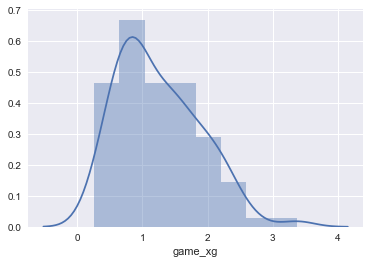

In [23]:
# look at overall distribution of expected goals against
sns.distplot(timbers_cb_xga['game_xg'])

In [24]:
# overall expected goals summary stats
timbers_cb_xga['game_xg'].describe()

count    88.000000
mean      1.248022
std       0.636576
min       0.254839
25%       0.764544
50%       1.103531
75%       1.689486
max       3.376729
Name: game_xg, dtype: float64

There are 88 observations (games) in our dataframe of expected goals against. The histogram and kernel density plot above shows a right skewed distribution of game_xg (expected goals against). There don't appear to be any extremely high outliers, with the max xGA at 3.377. The median xGA for all three seasons is 1.104

### Bivariate Plots and Summaries

#### xGA by Season

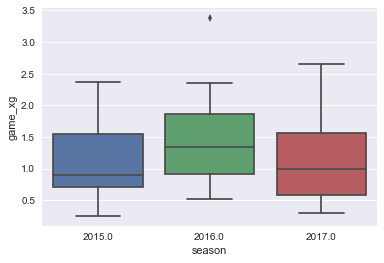

In [25]:
# xGA over 2015, 2016 and 2017 YTD seasons
sns.boxplot(data=timbers_cb_xga, x='season', y='game_xg')

In [27]:
# summary stats of xGa by season
timbers_cb_xga.groupby('season')['game_xg'].describe()

season       
2015.0  count    34.000000
        mean      1.125729
        std       0.585295
        min       0.254839
        25%       0.714703
        50%       0.898177
        75%       1.547133
        max       2.366427
2016.0  count    34.000000
        mean      1.408132
        std       0.615266
        min       0.524794
        25%       0.911063
        50%       1.350510
        75%       1.870040
        max       3.376729
2017.0  count    20.000000
        mean      1.183731
        std       0.725300
        min       0.294132
        25%       0.578774
        50%       0.991231
        75%       1.563656
        max       2.660504
Name: game_xg, dtype: float64

From the boxplot of game_xg by season and summar stats above, we can see an significant increase in median value from the 2015 to 2016 (+.452) which has dropped down (-.36) to .9912 for the 2017 season thus far. As most Timbers fans observed, last year, the 2016 season, saw a lapse in defensive performance, reflected in the xGA numbers and the win-loss recorod. So far, based on xGA, the 2017 season shows an improvement in defensive form.

#### xGA by Center Back Pairing

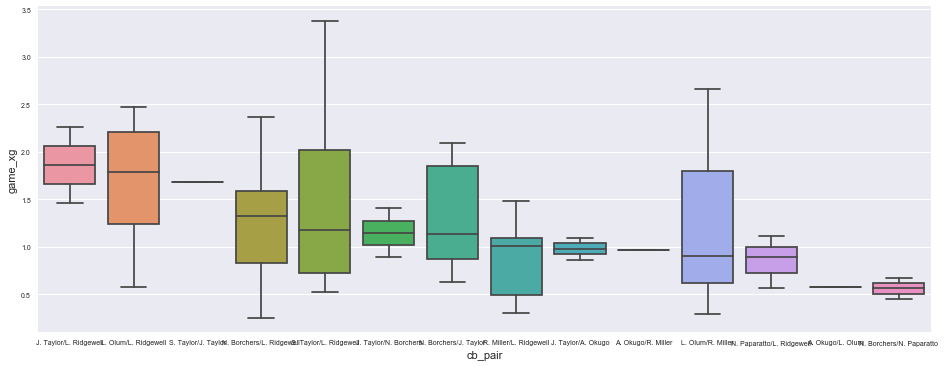

In [38]:
# generate boxplot of xGA by CB pairing
timbers_cb_xga['game_xg']= pd.to_numeric(timbers_cb_xga['game_xg'],errors='coerce')
ranks = timbers_cb_xga.groupby(
    'cb_pair')['game_xg'].median().fillna(0).sort_values()[::-1].index
a4_dims = (16,6)
ax = plt.subplots(figsize=a4_dims)
p = sns.boxplot(data=timbers_cb_xga, x='cb_pair', y='game_xg', order=ranks)
p.tick_params(labelsize=7)

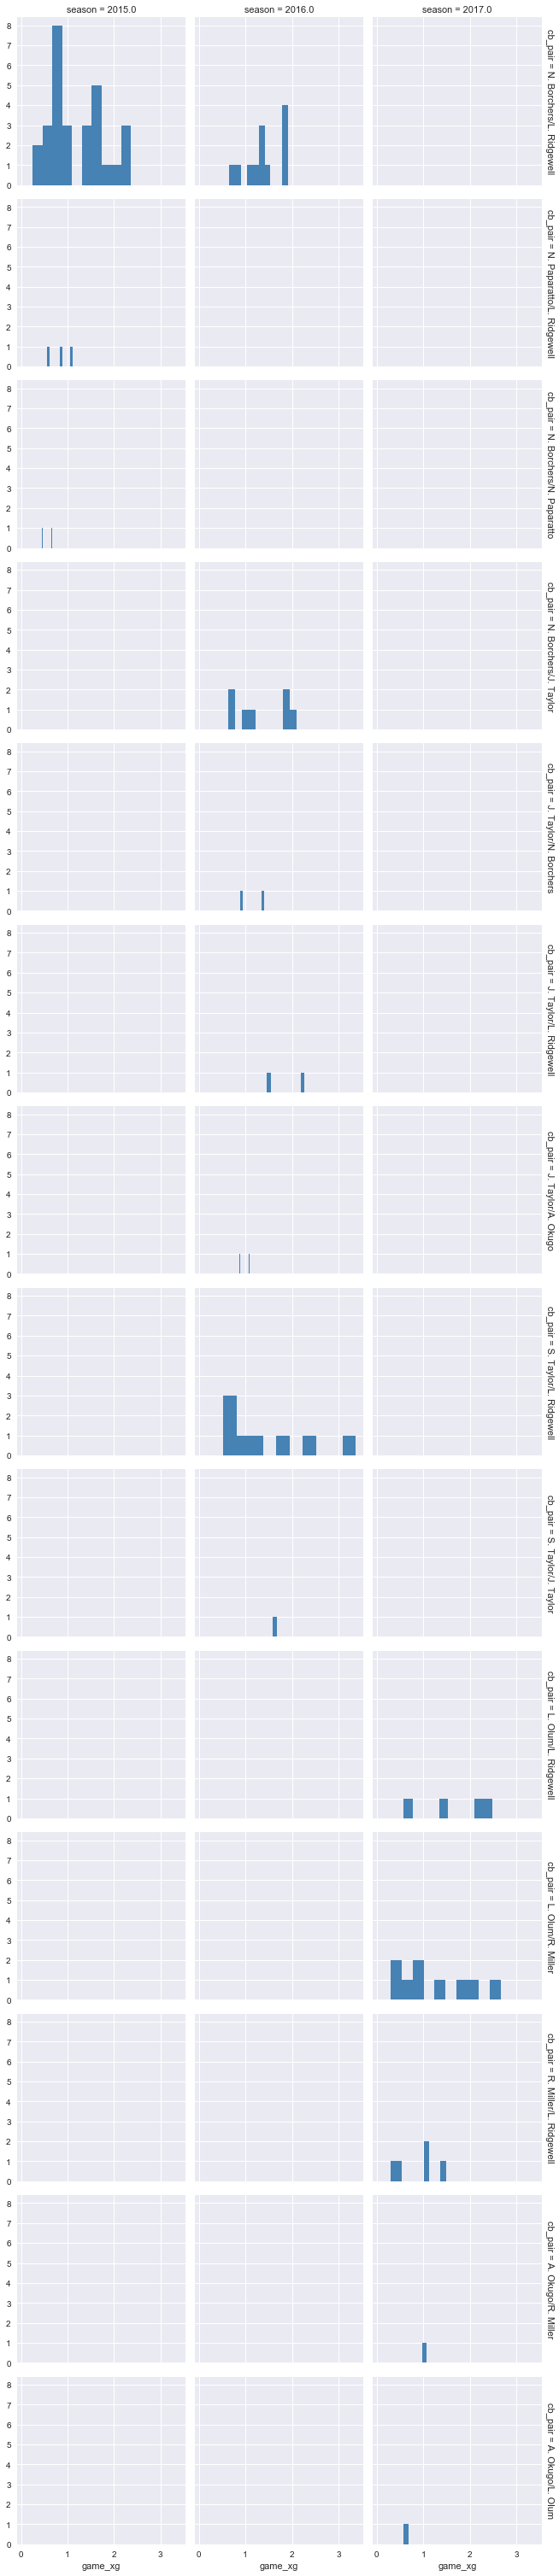

In [28]:
# distribution of xGA, faceted by season and by CB pairing
g = sns.FacetGrid(timbers_cb_xga, row="cb_pair", col="season", margin_titles=True)
g.map(plt.hist, "game_xg", color="steelblue")

We see some interesting things from the facetgrid above. For the 2015 season, Borchers/Ridgewell make almost all the starts, with some starts for Paparatto/Ridgewell, and Borchers/Ridgewell. Most of the starts Paparatto is involved in have xGA < 1. In the 2016 season, we see many more combinations of CB pairings, and the "Taylors" era with the 1 year tenure of Steven Taylor and Jermaine Taylor.

In 2017, there have been five CB pairing combinations so far.

In [46]:
pd.set_option('display.max_rows', 1000)
timbers_cb_xga.groupby('cb_pair')['game_xg'].describe()

cb_pair                         
A. Okugo/L. Olum           count     1.000000
                           mean      0.578150
                           std            NaN
                           min       0.578150
                           25%       0.578150
                           50%       0.578150
                           75%       0.578150
                           max       0.578150
A. Okugo/R. Miller         count     1.000000
                           mean      0.968382
                           std            NaN
                           min       0.968382
                           25%       0.968382
                           50%       0.968382
                           75%       0.968382
                           max       0.968382
J. Taylor/A. Okugo         count     2.000000
                           mean      0.979620
                           std       0.161585
                           min       0.865362
                           25%       0.922491
 

In terms of the original research question, which CB pairing has had the best xGA performance over the past few seasons, based on median value, the data suggest: Borchers/Paparrato, Okugo/Olum, Paparatto/Ridgewell, and Olum/Miller. Note that of these 5 best, only the combination of Olum/Miller exceeds 5 starts (9 so far). The distribution of Olum/Miller, although with a median value < 1 xGA, has some high values above 1.5. 

In [21]:
# export for further visualization work
timbers_cb_xga.to_csv('timbers_cb_xga.csv') 